In [180]:
import os
import re
import pandas as pd
import numpy as np
import torch
import onnx
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from nostril import nonsense_detector as nd
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from gensim.models import Doc2Vec
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm

In [181]:
# data
def get_data():
  engine_name = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
  engine = create_engine(engine_name)

  query_sql = "SELECT * FROM fb_data"
  df = pd.read_sql_query(query_sql, con=engine)
  return df

def process_text(text):
  TAG_RE = re.compile(r'<[^>]+>')
  text = TAG_RE.sub('',text)
  text = re.sub('[^a-zA-Z]', ' ', text)
  text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return simple_preprocess(text, deacc=True)

def map_label_to_class(label):
  SOURCES = {
    0: ["nytimes","cnn","nbc"],
    1: ["FoxNews","DailyMail","NYPost"],
    2: ["bbcnews","Reuters","APNews"]
  }

  for class_label, sources in SOURCES.items():
      if label in sources:
          return class_label
  raise ValueError(f"Label '{label}' not found in any source categories.")


def process_data(df):
  df['text'] = df['text'].apply(process_text)
  df['source'] = df['source'].apply(map_label_to_class)
  df.drop(columns=['id'])

  label_counts = df['source'].value_counts().sort_index()
  plt.bar(label_counts.index, label_counts.values, color=['blue', 'red', 'green'])
  plt.xticks(label_counts.index, ['left', 'right', 'center'])  
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.title('Count of Labels')
  plt.show()

  return df


In [182]:
# doc 2 vec
def create_d2v(df):
  print('Training doc2vec model')
  tagged =  [TaggedDocument(words=text, tags=[str(i)]) for i, text in enumerate(df['text'])]
  d2v_model = Doc2Vec(dm=1,vector_size=100,window=2,min_count=1,workers=4,epochs=20)
  d2v_model.build_vocab(tagged)
  d2v_model.train(utils.shuffle(tagged),total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
  print('Finished Training!!!')
  return d2v_model

In [183]:
# dataset initialization
class FBData(Dataset):
  def __init__(self,df,d2v_model):
    df.drop(columns=['id'])
    
    self.data = df
    self.d2v = d2v_model
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    text = self.data['text'][idx]
    label = self.data['source'][idx]
    vectorized_text = self.d2v.infer_vector(text)
    return torch.tensor(vectorized_text),torch.tensor(label)


In [184]:
# model

class BiasClassificationModel(nn.Module):
  def __init__(self,input_size,hidden_dim_1,hidden_dim_2,num_class):
    super(BiasClassificationModel,self).__init__()
    self.fc1 = nn.Linear(input_size,hidden_dim_1)
    self.fc2 = nn.Linear(hidden_dim_1,hidden_dim_2)
    self.fc3 = nn.Linear(hidden_dim_2,num_class)
    self.activation = nn.ReLU()
    self.softmax = nn.Softmax(dim=0)
  
  def forward(self,text):
    output = self.activation(self.fc1(text))
    output = self.activation(self.fc2(output))
    output = self.activation(self.fc3(output))
    return self.softmax(output)

In [185]:
# split data 
def split_data(dataset,batch_size):
  train_idx, test_idx = train_test_split(range(len(dataset)),test_size=0.2,random_state=42,shuffle=True)
  train_dataset = Subset(dataset,train_idx)
  test_dataset = Subset(dataset,test_idx)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_batch)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_batch)
  return train_loader, test_loader

In [186]:
# train and test
def train(dataloader,model,optimizer,criterion,verbose):
  model.train()
  train_loss = 0
  train_acc = 0
  total_samples = 0

  for text,label in tqdm(dataloader, disable=not verbose):
    optimizer.zero_grad()

    output = model(text)
    loss = criterion(output,label)

    train_loss += loss.item()
    train_acc += (output.argmax(1) == label).sum().item()
    total_samples += text.size(0)

    loss.backward()
    optimizer.step()

  train_loss/=total_samples
  train_acc/=total_samples

  return train_loss, train_acc, model, optimizer, criterion

def test(dataloader,model,criterion, verbose):
  model.eval()
  test_loss = 0
  test_acc = 0
  total_samples = 0
  test_preds = []
  test_labels = []

  with torch.no_grad():
    for text,label in tqdm(dataloader,disable=not verbose):
      output = model(text)
      loss = criterion(output,label)

      test_loss += loss.item()
      test_acc += (output.argmax(1) == label).sum().item()
      total_samples += text.size(0)

      test_preds.extend(output.argmax(1).cpu().numpy())
      test_labels.extend(label.cpu().numpy())
      
  test_loss/=total_samples
  test_acc/=total_samples
  return test_loss,test_acc, test_preds, test_labels

def train_test_loop(train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose):
  print('Training Starting')

  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(num_epochs):
    train_loss, train_acc, model, optimizer, criterion = train(train_loader,model,optimizer,criterion,verbose)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    if verbose: print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

    test_loss, test_acc, test_preds, test_labels  = test(test_loader,model,criterion,verbose)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if verbose: print(f'Test Epoch [{epoch + 1}/{num_epochs}], Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')
  
  print('Training Done, Final Testing Results Are As Shown:')

  print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
  print(f'Test Epoch [{epoch + 1}/{num_epochs}], Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')

  plt.plot(train_losses,label='Train Loss')
  plt.plot(test_losses,label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(train_accs,label='Train Acc')
  plt.plot(test_accs,label='Test Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy %')
  plt.legend()
  plt.show()

  cm = confusion_matrix(test_preds, test_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
  disp.plot(cmap='Blues')
  plt.title('Confusion Matrix: Predicted vs Actual Labels')
  plt.show()

In [187]:
def predict_text(text,model,d2v_model):
  tokenized_text = process_text(text)
  vectorized_text = d2v_model.infer_vector(tokenized_text)
  output = model(vectorized_text)
  prediction = output.argmax(1).item()

  if prediction == 0:
    prediction = 'left'
  elif prediction == 1:
    prediction = 'right'
  elif prediction == 2:
    prediction = 'center'
  else:
    raise ValueError(f"Prediction error.")

  print(f'The text provided leans towards the {prediction}')

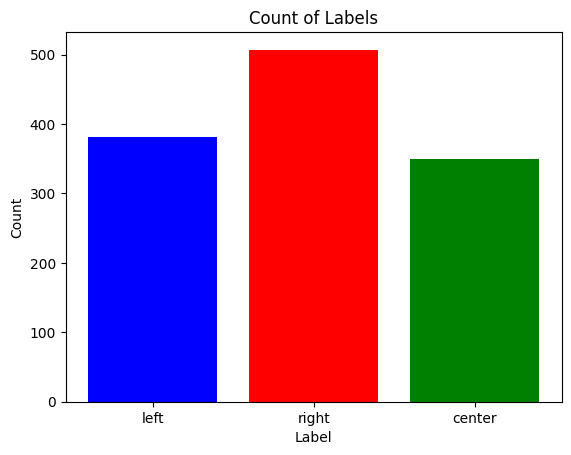

Training doc2vec model
Finished Training!!!
100
Training Starting


100%|██████████| 495/495 [00:01<00:00, 249.79it/s]


Training Epoch [1/10], Loss: 0.5398, Accuracy: 0.4475


100%|██████████| 124/124 [00:00<00:00, 387.37it/s]


Test Epoch [1/10], Loss: 0.5327, Accuracy: 0.4355


100%|██████████| 495/495 [00:02<00:00, 247.39it/s]


Training Epoch [2/10], Loss: 0.5295, Accuracy: 0.4525


100%|██████████| 124/124 [00:00<00:00, 383.35it/s]


Test Epoch [2/10], Loss: 0.5230, Accuracy: 0.4677


100%|██████████| 495/495 [00:02<00:00, 224.39it/s]


Training Epoch [3/10], Loss: 0.5150, Accuracy: 0.4778


100%|██████████| 124/124 [00:00<00:00, 373.44it/s]


Test Epoch [3/10], Loss: 0.5176, Accuracy: 0.4879


100%|██████████| 495/495 [00:02<00:00, 223.76it/s]


Training Epoch [4/10], Loss: 0.5206, Accuracy: 0.4717


100%|██████████| 124/124 [00:00<00:00, 309.06it/s]


Test Epoch [4/10], Loss: 0.5228, Accuracy: 0.4839


100%|██████████| 495/495 [00:02<00:00, 239.17it/s]


Training Epoch [5/10], Loss: 0.5255, Accuracy: 0.4869


100%|██████████| 124/124 [00:00<00:00, 389.84it/s]


Test Epoch [5/10], Loss: 0.5217, Accuracy: 0.4516


 88%|████████▊ | 436/495 [00:01<00:00, 254.88it/s]


KeyboardInterrupt: 

In [188]:
def main(text,batch_size,num_epochs,verbose):

  if nd.nonsense(text):
    raise Exception("Gibberish Text Detected") 
  
  df = get_data()
  df = process_data(df)
  d2v_model = create_d2v(df)
  dataset = FBData(df,d2v_model)
  train_loader, test_loader = split_data(dataset,batch_size)

  input_size = d2v_model.vector_size
  print(input_size)
  hidden_dim_1 = 64
  hidden_dim_2 = 32
  num_classes = 3

  model = BiasClassificationModel(input_size,hidden_dim_1,hidden_dim_2,num_classes)
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
  criterion = torch.nn.CrossEntropyLoss()

  train_test_loop(train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose)

  if(text is not None):
    predict_text(text,dataset,model,d2v_model)

text = "Breaking News: Hersh Goldberg-Polin, an American-Israeli who had been held in Gaza by Hamas for nearly 11 months, died in captivity, President Biden announced."
main(text,batch_size=2,num_epochs=10,verbose=True)